In [1]:
import numpy as np
import pandas as pd
import os
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import numpy as np
from dotenv import load_dotenv
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt


In [2]:
load_dotenv("../.env")

IP = os.getenv("IP_INFLUX_1")
PORT = os.getenv("PORT_INFLUX")
TOKEN = os.getenv("TOKEN_INFLUX")
ORG = os.getenv("ORG")
BUCKET = os.getenv("BUCKET")

In [3]:
client = InfluxDBClient(url=f"http://{IP}:{PORT}", token=TOKEN, org=ORG)
query_api = client.query_api()
# requete qui prend les 1000 points les plus récents, 
# les garde dans l'ordre chronologique et en fait une table avec les colonnes _time et value (via pivot pour meilleures performances) :
flux_query = f"""from(bucket:"{BUCKET}")
                    |> range(start: 0, stop: now())
                    |> filter(fn: (r) => r._measurement == "my_metric")
                    |> sort(columns: ["_time"], desc: true)
                    |> limit(n: 1000)
                    |> sort(columns: ["_time"], desc: false)
                    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
                    |> keep(columns: ["_time", "value"])
               """
               
records = query_api.query(flux_query)[0]
client.close()

In [33]:
dic = {"timestamp":[], "value":[]}
for record in records:
    dic["timestamp"].append(record.get_time())
    dic["value"].append(record.values["value"])
df = pd.DataFrame(dic)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

In [35]:
NB_POINTS = 1000
NB_PRED = 50
y_train = df[:-NB_PRED]

In [36]:
arima_model = ARIMA(endog=y_train, order=(1,1,2))
model = arima_model.fit()
y_pred = model.forecast(3)
y_true = df.value

/home/kyn/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/home/kyn/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/home/kyn/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [37]:
y_pred

2022-10-17 12:36:40+00:00     74.392849
2022-10-17 12:37:40+00:00    196.898925
2022-10-17 12:38:40+00:00    252.529878
Freq: T, Name: predicted_mean, dtype: float64

In [10]:
model.param_terms

['ar', 'ma', 'variance']

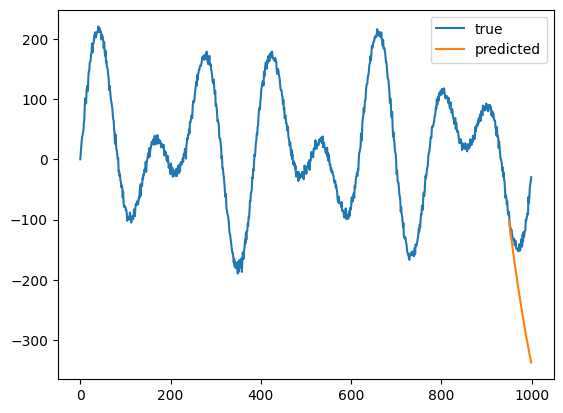

In [164]:
abscisses = np.arange(y_true.shape[0])

plt.plot(abscisses, y_true, label="true")
plt.plot(abscisses[-NB_PRED:], y_pred, label="predicted")
plt.legend()

Essai avec 2000 données :

In [172]:
client = InfluxDBClient(url=f"http://{IP}:{PORT}", token=TOKEN, org=ORG)
query_api = client.query_api()
flux_query = f"""from(bucket:"{BUCKET}")
                    |> range(start: 0, stop: now())
                    |> filter(fn: (r) => r._measurement == "my_metric")
                    |> sort(columns: ["_time"], desc: true)
                    |> limit(n: 2000)
                    |> sort(columns: ["_time"], desc: false)
                    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
                    |> keep(columns: ["_time", "value"])
               """
               
records = query_api.query(flux_query)
client.close()

In [167]:
dic = {"time":[], "value":[]}
for record in records:
    dic["time"].append(record.get_time())
    dic["value"].append(record.values["value"])
df = pd.DataFrame(dic)

In [178]:
NB_POINTS = 2000
NB_PRED = 50
y_train = df.value[:-NB_PRED-1]

arima_model = ARIMA(endog=y_train, order=(1,1,2))
model = arima_model.fit()
y_pred = model.predict(start=NB_POINTS-NB_PRED, end=NB_POINTS-1)
y_true = df.value

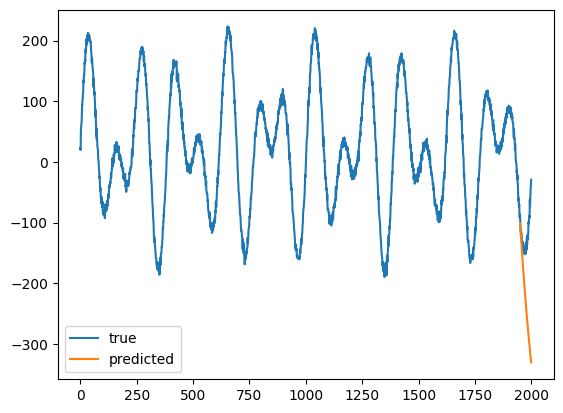

In [179]:
abscisses = np.arange(y_true.shape[0])

plt.plot(abscisses, y_true, label="true")
plt.plot(abscisses[-NB_PRED:], y_pred, label="predicted")
plt.legend()

Recherche meilleurs paramètres p, d, q d'ARIMA : (source : https://www.projectpro.io/article/how-to-build-arima-model-in-python/544)

paramètre d

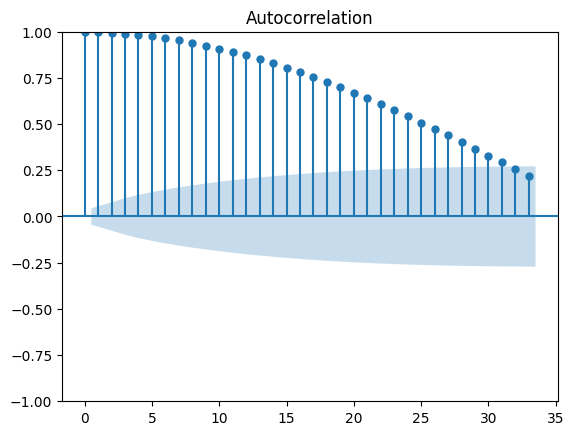

In [182]:
plot_acf(y_train)
plt.show()

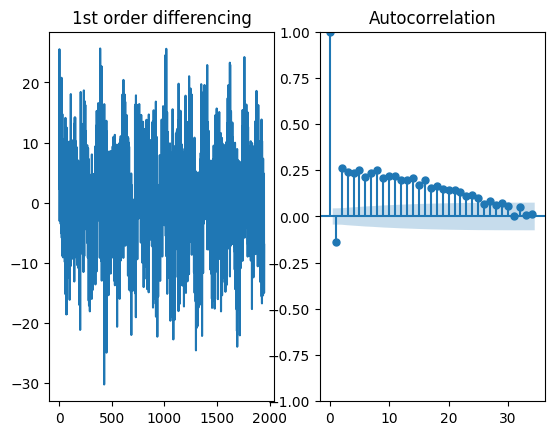

In [184]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(y_train.diff())

ax2 = f.add_subplot(122)
plot_acf(y_true.diff().dropna(), ax=ax2)
plt.show()

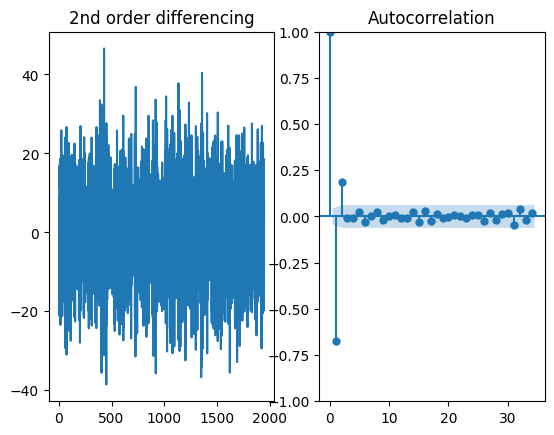

In [185]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("2nd order differencing")
ax1.plot(y_train.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(y_true.diff().diff().dropna(), ax=ax2)
plt.show()

Note : si besoin d'incrémental : https://stackoverflow.com/questions/66345248/partial-fit-or-incremental-learning-for-autoregressive-model